# Initial EDA / samples

Load external data sources, explore and produce samples for Roxana

In [1]:
%matplotlib inline
#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data
ext_data = os.path.join(top,'data/external/')

#Frontier data
front_data = os.path.join(top,'data/external/frontier/')

#Interim data
int_data = os.path.join(top,'data/interim/')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models/')

#Visualisations
viz_path = os.path.join(top,'src/visualization')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [2]:
def write_sample(file,name,rows=100):
    '''
    writes a sample of the data using a name and a number of rows (preset to 300)
    
    '''
    file.loc[:rows,:].to_csv(int_data+'/roxana_samples/{today_str}_{name}.csv'.
                                 format(today_str=today_str,name=name))
    
    
    

# BRES (NOMIS)

In [3]:
#Load BRES data and export sample (I know the contents of these data already)
bres_totals = pd.read_csv(ext_data+'/bres_creative_2015_16.csv')

bres_totals.loc[:50,:].to_csv(int_data+'/roxana_samples/{today_str}_bres_samples.csv'.format(today_str=today_str))

# IDBR (NOMIS)

In [4]:
#Load IDBR data and export sample (I know the contents of this)
idbr_totals = pd.read_csv(int_data+'/5_11_2017_idbr_totals.csv')
idbr_sizebands = pd.read_csv(int_data+'/5_11_2017_idbr_sizeband.csv')


idbr_all = pd.concat([idbr_totals,idbr_sizebands])

idbr_sizebands.loc[:200,:].to_csv(int_data+'/roxana_samples/{today_str}_idbr_sizeband_samples.csv'.
                                 format(today_str=today_str))

In [5]:
#pd.pivot_table(
#    idbr_all.groupby(['sector','sizeband','year','ttwa_name'])['value'].sum().reset_index(),
#    index=['sector','sizeband','ttwa_name'],columns='year',values='value',aggfunc='sum')

# IDBR (VML)

In [6]:
#Load IDBR data, eyeball and export sample

idbr_vml = pd.read_excel(ext_data+'/frontier/spd-creative clusters counts and LQs-06-11-2017.xlsx',sheetname=4)

write_sample(idbr_vml,'idbr_vml_2016')


/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [10]:
len(set(idbr_vml['TTWA name']))

51

# ABS (VML)
    

In [7]:
#Load ABS data
abs_vml = [pd.read_excel(ext_data+'/frontier/spd-ABS creative clusters-21-09-2017.xlsx',sheetname=x) for x in [1,2]]

In [8]:
write_sample(abs_vml[0],'abs_2013_15_sectors.csv',len(abs_vml[0]))
write_sample(abs_vml[0],'abs_2013_15_creative_regions.csv',len(abs_vml[0]))

# Survival (VML)

In [9]:
ttwa_name_df = idbr_all.drop_duplicates('ttwa_code')[['ttwa_code','ttwa_name']].reset_index(drop=True)
ttwa_name_lookup = {x:y for x,y in zip(ttwa_name_df.ttwa_code, ttwa_name_df.ttwa_name)}

ttwa_region_df = pd.read_excel(ext_data+'/geography_of_creativity_data.xlsx',sheetname=0)

ttwa_region_lookup = {x:y for x,y in zip(ttwa_region_df.TTWA,ttwa_region_df.region)}

ttwa_is_cluster = list(ttwa_region_df.loc[ttwa_region_df.creative_cluster=='yes','TTWA'])


#This is where it starts to gets interesting

survival = pd.read_excel(ext_data+'/frontier/spd-survival statistics-06-11-2017-STC.xlsx',sheetname=4)
survival['ttwa_name'] = [ttwa_name_lookup[x] for x in survival['ttwa']]


#Survival long
survival_long = pd.melt(survival,id_vars=['ttwa_name','ttwa','industry'])

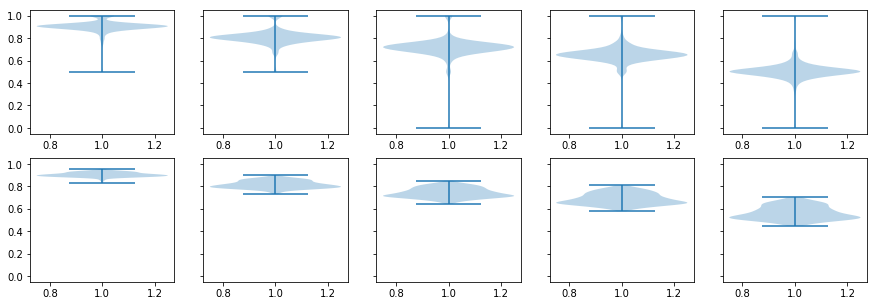

In [10]:
#Contains data for all TTWAs.

fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(15,5),sharey=True)

for x in np.arange(5):
    ax[0][x].violinplot(survival.loc[[x == 'Creative' for x in survival.industry],
                                  'surv_t_rate_{val}'.format(val=x+1)].values)

for x in np.arange(5):
    ax[1][x].violinplot(survival.loc[[x != 'Creative' for x in survival.industry],
                                  'surv_t_rate_{val}'.format(val=x+1)].values)


In [11]:
from scipy.stats import ttest_ind

In [12]:
test =ttest_ind(survival.loc[survival.industry=='Creative','surv_t_rate_5'],
         survival.loc[survival.industry!='Creative','surv_t_rate_5'])

In [46]:
#Focus on top 100 TTWAs

top_100 = idbr_all.loc[(idbr_all['year']==2016) 
             & (idbr_all['sizeband']=='Total') & (idbr_all['sector']=='creative_industries'),
             ['ttwa_name','value']].sort_values('value',ascending=False)[:100]['ttwa_name']


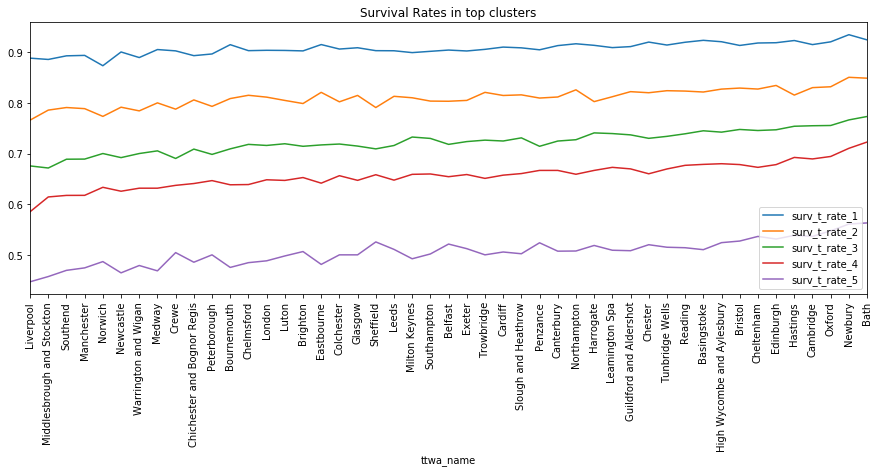

In [79]:
fig,ax = plt.subplots(figsize=(15,5))

#Compare regions
survival['region'] = [ttwa_region_lookup[x] if x in ttwa_region_lookup.keys() else np.nan for x in survival.ttwa_name]


survival_creative = survival.loc[
    (survival.industry=='Creative') & ([x in ttwa_is_cluster for x in survival.ttwa_name])
    ,[any(w in x for w in ['ttwa','rate']) for x in survival.columns]].set_index('ttwa_name')

survival_creative['mean'] = survival_creative.mean(axis=1)
survival_sorted = survival_creative.sort_values('mean')

survival_sorted.drop('mean',axis=1).plot(ax=ax)

ax.set_xticks(np.arange(len(survival_creative)))
ax.set_xticklabels(survival_sorted.index,rotation=90)

ax.set_title('Survival Rates in top clusters')

#Seems to get quite noisy for smaller regions

In [81]:
write_sample(survival,'survival_rates')

## Growth dynamics (VML)

In [82]:
growth_dynamics = pd.read_excel(ext_data+'frontier/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheetname=7)

In [88]:
growth_dynamics['ttwa'] = [ttwa_name_lookup[x] if x in ttwa_name_lookup.keys() else np.nan for x in growth_dynamics.ttwa]

In [92]:
#Only a small number of the cluster TTWAs are missing 
set(ttwa_is_cluster) - set(growth_dynamics.ttwa)

{'Bath',
 'Canterbury',
 'Cheltenham',
 'Chichester and Bognor Regis',
 'Hastings',
 'Penzance',
 'Southend',
 'Trowbridge'}

In [95]:
#We have two periods
set(growth_dynamics.cohort)

{'200709-201012', '201013-201316'}

In [240]:
growth_dynamics.head()

,bandemployment,cohort,ttwa,employment_start,employment_end,turnover_start,turnover_end,entref,d_employment,d_turnover,mnentref,industry
0,birth,200709-201012,Barnsley,0,14940,0,1150540,4475,14940,1150540,15,Other
1,bl10dec,200709-201012,Barnsley,7070,4240,537280,407440,1660,-2830,-129840,15,Other
2,bl10inc,200709-201012,Barnsley,7060,13790,842620,1263350,2440,6730,420730,15,Other
3,bl10sm,200709-201012,Barnsley,10370,10370,917860,902920,4965,0,-14930,15,Other
4,bv10dec,200709-201012,Barnsley,76580,57560,10909920,8624380,935,-19020,-2285540,15,Other


In [129]:
#Produce creative stats
creative_gd_latest = growth_dynamics.loc[(growth_dynamics['cohort']=='201013-201316') &
                    (growth_dynamics['industry']=='All creative'),['d_employment','bandemployment','ttwa']]

creative_wide = pd.pivot_table(creative_gd_latest,index='ttwa',columns='bandemployment',values='d_employment')

job_creators = creative_wide.sum(axis=1).sort_values().index

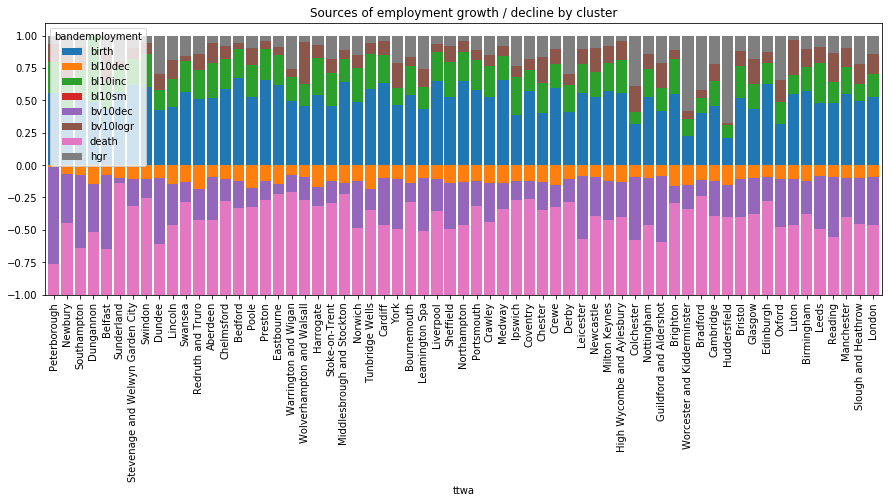

In [241]:
fig,ax = plt.subplots(figsize=(15,5))

creative_wide.loc[job_creators,:].plot.bar(stacked=True,ax=ax,width=0.85)
ax.set_title('Sources of employment growth / decline by cluster')

In [131]:
pos = list(creative_wide.sum().index[creative_wide.sum()>1])

In [133]:
creative_gd_latest['pos'] = [True if x in pos else False for x in creative_gd_latest['bandemployment']]

In [143]:
def get_ratio(df,var='d_employment'):
    '''
    Normalises the column
    
    '''
    
    df['ratio'] = df[var]/abs(df[var].sum())
    return(df)


creative_gd_ratio = creative_gd_latest.groupby(['ttwa','pos']).apply(lambda x: get_ratio(x))

In [182]:
creative_wide_ratio = pd.pivot_table(
    creative_gd_ratio.loc[[x in ttwa_is_cluster for x in creative_gd_ratio.ttwa],:],index='ttwa',columns='bandemployment',values='ratio')

scale_up_clusters = creative_wide_ratio['birth'].sort_values().index


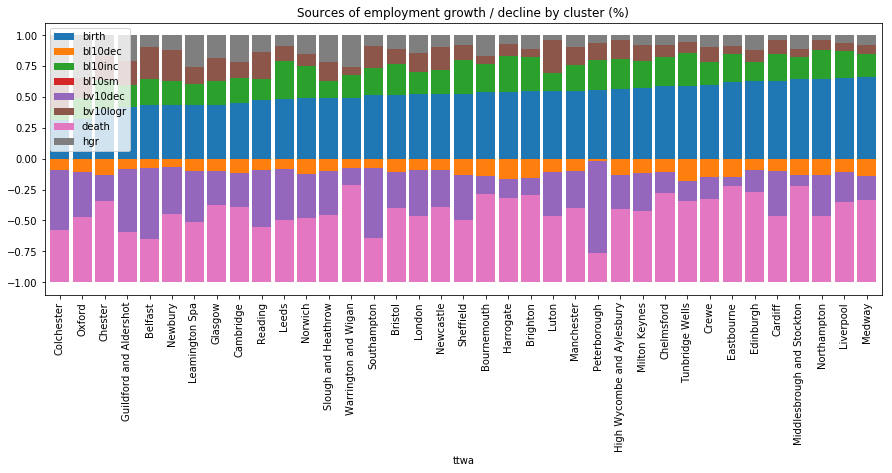

In [183]:
fig,ax = plt.subplots(figsize=(15,5))

creative_wide_ratio.loc[scale_up_clusters,:].plot.bar(stacked=True,ax=ax,width=0.85)
ax.set_title('Sources of employment growth / decline by cluster (%)')

ax.legend(loc=2)

In [189]:
#Calculate churn
creative_gd_latest = growth_dynamics.loc[(growth_dynamics['cohort']=='201013-201316') &
                    (growth_dynamics['industry']=='All creative'),['entref','bandemployment','ttwa']]



creative_gd_churn = pd.pivot_table(creative_gd_latest,index='ttwa',columns='bandemployment',values='entref')

In [237]:
#Create different measures of activity
creative_gd_churn['churn'] = creative_gd_churn.apply(lambda x: (x['birth']+x['death'])/x.sum(),axis=1)
creative_gd_churn['stasis'] = creative_gd_churn.apply(lambda x: (x['bv10dec']+x['bl10dec']+x['bl10sm'])/x.sum(),axis=1)

In [238]:
#How do they compare with employment growth
emp_growth = pd.pivot_table(bres_totals[['ttwa_name','creative_industries','year']],
                            index='ttwa_name',columns='year',values='creative_industries')
emp_growth['growth']=emp_growth[2016]/emp_growth[2015]


cluster_churn_growth = pd.concat([creative_gd_churn,emp_growth],axis=1).dropna(axis=0,subset=['growth'])


cluster_churn_growth[['churn','growth']].corr()

,churn,growth
churn,1.000000,-0.131441
growth,-0.131441,1.000000


In [239]:
cluster_churn_growth[['stasis','growth']].corr()

,stasis,growth
stasis,1.000000,0.087724
growth,0.087724,1.000000
